# Load Data

In [ ]:
!pip install gdown --q

In [ ]:
!pip install kaggle --q

In [ ]:
!kaggle datasets download -d minhnh2107/casiafasd

Dataset URL: https://www.kaggle.com/datasets/minhnh2107/casiafasd
License(s): unknown
100% 70.6M/70.6M [00:05<00:00, 19.7MB/s]
100% 70.6M/70.6M [00:05<00:00, 13.7MB/s]


In [ ]:
!kaggle datasets download -d minhnh2107/casiafasd

Dataset URL: https://www.kaggle.com/datasets/minhnh2107/casiafasd
License(s): unknown
 81% 57.0M/70.6M [00:00<00:00, 156MB/s]
100% 70.6M/70.6M [00:00<00:00, 168MB/s]


In [ ]:
!unzip casiafasd.zip

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
def load_image_paths(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(directory, filename))
    return image_paths

image_paths = load_image_paths('/content/train_img/train_img/color')

In [7]:
output_dir = '/content/train_img/train_img/color'

/content/train_img/train_img/color
/content/train_img/train_img/color/16_HR_4.avi_50_fake.jpg
/content/train_img/train_img/color/7_6.avi_175_fake.jpg
/content/train_img/train_img/color/8_6.avi_50_fake.jpg
/content/train_img/train_img/color/9_5.avi_25_fake.jpg
/content/train_img/train_img/color/17_6.avi_50_fake.jpg
/content/train_img/train_img/color/4_7.avi_200_fake.jpg
/content/train_img/train_img/color/1_4.avi_75_fake.jpg
/content/train_img/train_img/color/17_7.avi_75_fake.jpg
/content/train_img/train_img/color/2_HR_1.avi_300_real.jpg
/content/train_img/train_img/color/14_7.avi_125_fake.jpg


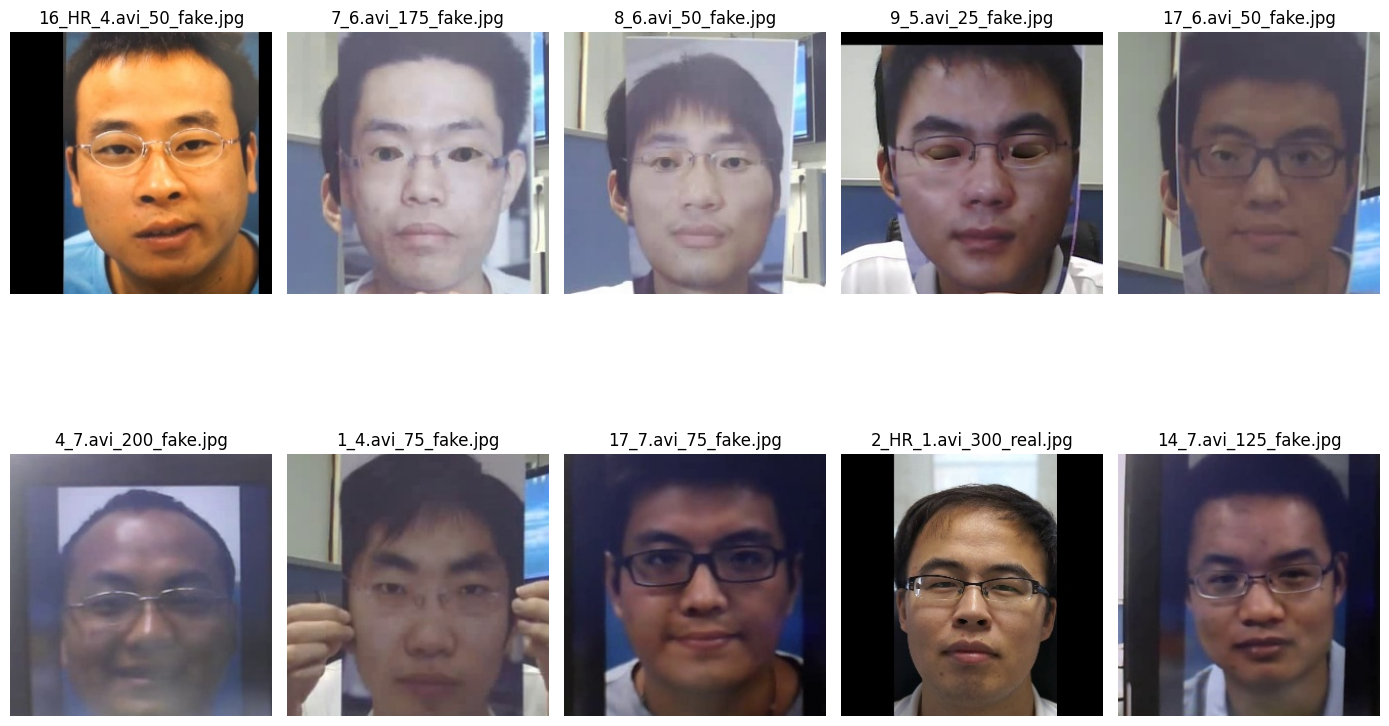

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to display images
def show_images(image_paths):
    plt.figure(figsize=(14, 10))  # Adjust figure size as needed
    for i in range(10):
          image_path = image_paths[i]
          print(image_path)
          image = Image.open(image_path)
          plt.subplot(2, 5, i + 1)  # Display in 2x5 grid
          plt.imshow(image)
          plt.axis('off')
          plt.title(os.path.basename(image_path))
    plt.tight_layout()
    plt.show()

# Display 10 images
print(output_dir)
show_images(load_image_paths(output_dir))

In [9]:
len(image_paths)

1655

## Labels Extraction

In [25]:
train_labels = []
for path in image_paths:
    # Split the path by '/' and get the last part (filename)
    filename = os.path.basename(path)
    # Split the filename by '_' and get the second last part (label)
    label = filename.split('_')[-1].split('.')[0]  # Assuming label is second last part before '.jpg' or '.png'
    train_labels.append(label)

In [26]:
len(train_labels)

1655

In [27]:
train_labels_binary = []
for label in train_labels:
  if label == 'fake':
    train_labels_binary.append(0)
  else:
    train_labels_binary.append(1)

In [28]:
train_labels_binary[0]

0

## Load [Our Own Data](https://drive.google.com/file/d/1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA/view?usp=sharing)

In [14]:
import gdown

file_id = '1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA'
destination = '/content/dataset.zip'  # Path where the file will be saved
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

import zipfile

with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

Downloading...
From (original): https://drive.google.com/uc?id=1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA
From (redirected): https://drive.google.com/uc?id=1a5R5h05hCyw9PzIBhSjy2jLL3dSFy2xA&confirm=t&uuid=3e1c5557-4ed5-4611-87b4-2a0fe8ff00c4
To: /content/dataset.zip
100%|██████████| 377M/377M [00:13<00:00, 28.8MB/s]


### Random Frame Extraction

In [16]:
import random

def extract_frames(video_path, save_path, label):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Select one random frame
    random_frame = random.randint(0, frame_count - 1)

    # Set the position of the video to the selected frame
    video.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
    success, frame = video.read()

    # If the frame was successfully read, save it
    if success:
        frame_path = os.path.join(save_path, f"{label}_{random_frame}.jpg")
        cv2.imwrite(frame_path, frame)

    # Release the video file
    video.release()

In [18]:
import cv2

fake_test_videos_path = '/content/dataset/fake/test'
fake_train_videos_path = '/content/dataset/fake/train'
real_test_videos_path = '/content/dataset/real/test'
real_train_videos_path = '/content/dataset/real/train'

save_frames_path = '/content/frames/test'
# Create the directory if it doesn't exist
if not os.path.exists(save_frames_path):
    os.makedirs(save_frames_path)

# Iterate over fake videos and extract frames
for fake_video_file in os.listdir(fake_test_videos_path):
    fake_video_path = os.path.join(fake_test_videos_path, fake_video_file)
    extract_frames(fake_video_path, save_frames_path, 0)

# Iterate over real videos and extract frames
for real_video_file in os.listdir(real_test_videos_path):
    real_video_path = os.path.join(real_test_videos_path, real_video_file)
    extract_frames(real_video_path, save_frames_path, 1)


# Iterate over fake videos and extract frames
for fake_video_file in os.listdir(fake_train_videos_path):
    fake_video_path = os.path.join(fake_train_videos_path, fake_video_file)
    extract_frames(fake_video_path, save_frames_path, 0)

# Iterate over real videos and extract frames
for real_video_file in os.listdir(real_train_videos_path):
    real_video_path = os.path.join(real_train_videos_path, real_video_file)
    extract_frames(real_video_path, save_frames_path, 1)

In [21]:
paths = load_image_paths(save_frames_path)

In [22]:
len(paths)

72

In [23]:
# Shuffle the list of paths
random.shuffle(paths)

# Select the first 15 paths for the test set
test_paths = paths[:15]

# The remaining paths can be used for training or validation
remaining_paths = paths[15:]

print("Test paths:", test_paths)
print("Remaining paths:", remaining_paths)

Test paths: ['/content/frames/test/0_30.jpg', '/content/frames/test/0_127.jpg', '/content/frames/test/1_46.jpg', '/content/frames/test/1_13.jpg', '/content/frames/test/1_87.jpg', '/content/frames/test/0_66.jpg', '/content/frames/test/0_87.jpg', '/content/frames/test/0_97.jpg', '/content/frames/test/0_0.jpg', '/content/frames/test/0_155.jpg', '/content/frames/test/1_21.jpg', '/content/frames/test/0_6.jpg', '/content/frames/test/0_181.jpg', '/content/frames/test/0_11.jpg', '/content/frames/test/0_5.jpg']
Remaining paths: ['/content/frames/test/0_10.jpg', '/content/frames/test/1_49.jpg', '/content/frames/test/1_14.jpg', '/content/frames/test/0_99.jpg', '/content/frames/test/0_32.jpg', '/content/frames/test/1_29.jpg', '/content/frames/test/1_136.jpg', '/content/frames/test/1_57.jpg', '/content/frames/test/0_25.jpg', '/content/frames/test/1_10.jpg', '/content/frames/test/0_14.jpg', '/content/frames/test/0_76.jpg', '/content/frames/test/0_34.jpg', '/content/frames/test/1_17.jpg', '/content/f

In [29]:
for path in remaining_paths:
    # Split the path by '/' and get the last part (filename)
    filename = os.path.basename(path)
    # Split the filename by '_' and get the second last part (label)
    label = int(filename.split('_')[0])  # Assuming label is second last part before '.jpg' or '.png'
    # if (label != 0 and label != 1):
    #   print(path)
    train_labels_binary.append(label)

In [30]:
len(train_labels_binary)

1712

In [31]:
train_labels_binary[1600]

0

In [32]:
train_image_paths = []
for image_path in image_paths:
  train_image_paths.append(image_path)

our_train = remaining_paths
for image_path in our_train:
  train_image_paths.append(image_path)

test_image_paths = []

our_test = test_paths
for image_path in our_test:
  test_image_paths.append(image_path)

In [33]:
len(train_image_paths)

1712

In [35]:
test_image_paths[12]

'/content/frames/test/0_181.jpg'

#### Labels

In [36]:
test_labels_binary = []
for path in test_image_paths:
    # Split the path by '/' and get the last part (filename)
    filename = os.path.basename(path)
    # Split the filename by '_' and get the second last part (label)
    label = int(filename.split('_')[0])  # Assuming label is second last part before '.jpg' or '.png'
    test_labels_binary.append(label)

In [37]:
len(test_image_paths)

15

In [38]:
len(test_labels_binary)

15

# ResNet50

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2

## Preparing Images

In [40]:
import numpy as np
from PIL import Image

# Assuming images is a list of PIL Image objects
train_images_np = []

for image_path in train_image_paths:
    image = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_np = np.array(rgb_img)
    train_images_np.append(img_np)

# Now images_np should contain numpy arrays representing each image
print(train_images_np[0].shape)  # Check the shape of the first image numpy array

(256, 256, 3)


In [41]:
# Assuming images is a list of PIL Image objects
test_images_np = []

for image_path in test_image_paths:
    image = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_np = np.array(rgb_img)
    test_images_np.append(img_np)

# Now images_np should contain numpy arrays representing each image
print(test_images_np[0].shape)  # Check the shape of the first image numpy array

(720, 1280, 3)


In [42]:
# Resize images to (224, 224, 3)
train_images_resized = np.array([cv2.resize(img, (224, 224)) for img in train_images_np])

# Verify the shape of the resized images
print(train_images_resized.shape)

# Resize images to (224, 224, 3)
test_images_resized = np.array([cv2.resize(img, (224, 224)) for img in test_images_np])

# Verify the shape of the resized images
print(test_images_resized.shape)

(1712, 224, 224, 3)
(15, 224, 224, 3)


## Preparing Labels

In [43]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [44]:
for i in range (0, len(train_labels_binary)):
  if not (train_labels_binary[i] == 0 or train_labels_binary[i] == 1):
    print(i)

In [46]:
train_labels_binary[1660]

1

# Training the model

In [47]:
# One-hot encode the labels
train_labels_binary_onehot = to_categorical(np.array(train_labels_binary), num_classes=2)
test_labels_binary_onehot = to_categorical(np.array(test_labels_binary), num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(train_images_resized, train_labels_binary_onehot, test_size=0.1, random_state=42)

In [48]:
# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Adjust to match your number of classes

94765736/94765736 [==============================] - 2s 0us/step


In [49]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [50]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
49/49 [==============================] - 16s 160ms/step - loss: 0.5268 - accuracy: 0.8617 - val_loss: 0.0606 - val_accuracy: 0.9709
Epoch 2/10
49/49 [==============================] - 5s 95ms/step - loss: 0.0293 - accuracy: 0.9942 - val_loss: 0.0675 - val_accuracy: 0.9884
Epoch 3/10
49/49 [==============================] - 5s 103ms/step - loss: 0.0128 - accuracy: 0.9981 - val_loss: 0.0327 - val_accuracy: 0.9884
Epoch 4/10
49/49 [==============================] - 5s 100ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.0511 - val_accuracy: 0.9942
Epoch 5/10
49/49 [==============================] - 5s 100ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0.9942
Epoch 6/10
49/49 [==============================] - 5s 101ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0378 - val_accuracy: 0.9942
Epoch 7/10
49/49 [==============================] - 5s 97ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 0.9942
Epoch 8

In [51]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

6/6 [==============================] - 1s 85ms/step - loss: 0.0417 - accuracy: 0.9942
Test Loss: 0.04171567037701607, Test Accuracy: 99.41860437393188%


In [52]:
# Save the model
model.save('anti_spoofing_model_resnet50_deep_fullface.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
len(test_images_resized)

15

## Testing the model

In [54]:
test_loss, test_accuracy = model.evaluate(test_images_resized, test_labels_binary_onehot)

1/1 [==============================] - 2s 2s/step - loss: 0.1291 - accuracy: 0.9333


### Wrong Answers

In [55]:
import os

# Directory containing the images
image_directory = '/content/frames/test'  # Replace with the actual image directory

# Get the predicted labels for the test images
predictions = model.predict(test_images_resized)
predicted_labels = np.argmax(predictions, axis=1)

print("Total test images: ", len(predicted_labels))
# Get the true labels
true_labels = np.argmax(test_labels_binary_onehot, axis=1)

# Find the names of incorrectly classified images
incorrect_image_names = []
for index, (predicted_label, true_label) in enumerate(zip(predicted_labels, true_labels)):
    if predicted_label != true_label:
        image_name = os.listdir(image_directory)[index]
        incorrect_image_names.append(image_name)
print("Wrong: ", len(incorrect_image_names))
# Display the names of incorrectly classified images
for image_name in incorrect_image_names:
    print(f"Incorrectly classified image: {image_name}")

1/1 [==============================] - 1s 1s/step
Total test images:  15
Wrong:  1
Incorrectly classified image: 1_45.jpg


# Testing Google model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

In [ ]:
# Step 1: Load pretrained model and processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Freeze the base model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head
model.classifier = nn.Linear(model.config.hidden_size, 2)
nn.init.xavier_uniform_(model.classifier.weight)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Step 2: Convert data to PyTorch tensors and permute dimensions
# Normalize the image data
X_train_pt = torch.tensor(X_train / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test_pt = torch.tensor(X_test / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_pt = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_pt = torch.tensor(y_test, dtype=torch.long).to(device)


In [ ]:
# Step 3: Define optimizer and criterion for the classifier head
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5)  # Only optimize classifier parameters
criterion = nn.CrossEntropyLoss()

In [ ]:
# Step 4: Training loop
model.train()
epochs = 15
batch_size = 32

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train_pt[i:i+batch_size]
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, torch.argmax(batch_labels, dim=1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/15, Loss: 37.11098554730415
Epoch 2/15, Loss: 35.99433559179306
Epoch 3/15, Loss: 34.94117975234985
Epoch 4/15, Loss: 33.94147551059723
Epoch 5/15, Loss: 32.99218416213989
Epoch 6/15, Loss: 32.090433061122894
Epoch 7/15, Loss: 31.23355120420456
Epoch 8/15, Loss: 30.41901633143425
Epoch 9/15, Loss: 29.644426703453064
Epoch 10/15, Loss: 28.90748021006584
Epoch 11/15, Loss: 28.205973237752914
Epoch 12/15, Loss: 27.537800580263138
Epoch 13/15, Loss: 26.900960713624954
Epoch 14/15, Loss: 26.293553680181503
Epoch 15/15, Loss: 25.713781982660294


In [ ]:
# Step 5: Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use a smaller learning rate for fine-tuning the entire model
optimizer = optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.BCEWithLogitsLoss()  # Use this if model outputs logits

# Ensure your targets are float
y_train_pt = torch.tensor(y_train_pt, dtype=torch.float)
y_test_pt = torch.tensor(y_test_pt, dtype=torch.float)

# Training loop remains similar
for epoch in range(15):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train_pt[i:i+batch_size]
        batch_labels = y_train_pt[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(pixel_values=batch_inputs)
        loss = criterion(outputs.logits, batch_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Fine-tuning Epoch {epoch+1}/{15}, Train Loss: {total_loss:.4f}")


<ipython-input-169-391ac97d86a6>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_pt = torch.tensor(y_train_pt, dtype=torch.float)
<ipython-input-169-391ac97d86a6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_pt = torch.tensor(y_test_pt, dtype=torch.float)


Fine-tuning Epoch 1/15, Train Loss: 32.1914
Fine-tuning Epoch 2/15, Train Loss: 21.3761
Fine-tuning Epoch 3/15, Train Loss: 16.4661
Fine-tuning Epoch 4/15, Train Loss: 12.6109
Fine-tuning Epoch 5/15, Train Loss: 9.5703
Fine-tuning Epoch 6/15, Train Loss: 7.2279
Fine-tuning Epoch 7/15, Train Loss: 5.4843
Fine-tuning Epoch 8/15, Train Loss: 4.2224
Fine-tuning Epoch 9/15, Train Loss: 3.3178
Fine-tuning Epoch 10/15, Train Loss: 2.6637
Fine-tuning Epoch 11/15, Train Loss: 2.1786
Fine-tuning Epoch 12/15, Train Loss: 1.8078
Fine-tuning Epoch 13/15, Train Loss: 1.5194
Fine-tuning Epoch 14/15, Train Loss: 1.2910
Fine-tuning Epoch 15/15, Train Loss: 1.1079


In [ ]:
# Normalize the image data
X_train_pt = torch.tensor(X_train / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test_pt = torch.tensor(test_images_resized / 255.0, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_pt = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_pt = torch.tensor(test_labels_binary_onehot, dtype=torch.long).to(device)

In [ ]:
import torch

# Ensure your model and tensors are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assuming X_test_pt and y_test_pt are preprocessed and available on the correct device
X_test_pt = X_test_pt.to(device)
y_test_pt = y_test_pt.to(device)

# Set the model to evaluation mode
model.eval()
correct = 0
total = 0
batch_size = 32  # Set your batch size

with torch.no_grad():
    for i in range(0, len(X_test_pt), batch_size):
        batch_inputs = X_test_pt[i:i+batch_size]
        batch_labels = y_test_pt[i:i+batch_size]

        # Ensure the inputs are on the correct device
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(pixel_values=batch_inputs)
        _, predicted = torch.max(outputs.logits, 1)

        total += batch_labels.size(0)
        correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

accuracy = 100 * correct / total
print(f"Final Accuracy on test set: {accuracy:.2f}%")


Final Accuracy on test set: 84.50%
